In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from fuzzywuzzy import fuzz
from scipy import stats

C:\Users\Dhireen Kumar Rajak\AppData\Roaming\Python\Python312\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [54]:
data = pd.read_csv('synthetic_dataset.csv')

In [55]:
# Function to calculate the number of days from Invoice Date to Payment Date
def calculate_days_from_invoice_to_payment(data):
    # Convert 'Invoice Date' and 'Payment Date' to datetime
    data['Invoice Date'] = pd.to_datetime(data['Invoice Date'], errors='coerce')
    data['Payment Date'] = pd.to_datetime(data['Payment Date'], errors='coerce')
    
    # Calculate the difference between 'Payment Date' and 'Invoice Date' in days
    data['Days_from_Invoice_to_Payment'] = (data['Payment Date'] - data['Invoice Date']).dt.days
    
    # Handle missing values by filling with a placeholder, or you could drop them
    data['Days_from_Invoice_to_Payment'].fillna(-1, inplace=True)
    
    return data

In [56]:
# Function to apply One-Class SVM for anomaly detection on a specific feature
def detect_anomalies_with_ocsvm(data, feature_name, nu=0.1, gamma='scale'):
    # Extract the feature and reshape for One-Class SVM
    feature = data[feature_name].values.reshape(-1, 1)
    
    # Scale the feature
    scaler = StandardScaler()
    feature_scaled = scaler.fit_transform(feature)
    
    # Train the One-Class SVM
    ocsvm = OneClassSVM(kernel='rbf', nu=nu, gamma=gamma)
    ocsvm.fit(feature_scaled)
    
    # Predict anomalies (-1 indicates anomaly, 1 indicates normal)
    predictions = ocsvm.predict(feature_scaled)
    
    # Add the anomaly column to the dataframe
    data[f'{feature_name} Anomaly'] = np.where(predictions == -1, 'Anomaly', 'Normal')
    
    return data

In [57]:
# Function to detect irregular currency patterns (supplier-specific anomalies)
def detect_irregular_currency_pattern(data):
    # Ensure column names are correctly named and clean
    data.columns = data.columns.str.strip()  # Strip any extra spaces in column names
    
    # Step 1: Check if 'Supplier Name' and 'Currency Code' are available
    if 'Supplier Name' not in data.columns or 'Currency Code' not in data.columns:
        raise ValueError("The dataset must contain 'Supplier Name' and 'Currency Code' columns")
    
    # Step 2: Handle missing values in 'Currency Code' or 'Supplier Name'
    data['Currency Code'].fillna('Unknown', inplace=True)
    data['Supplier Name'].fillna('Unknown Supplier', inplace=True)
    
    # Step 3: Find the most common currency used by each supplier
    most_common_currency = data.groupby('Supplier Name')['Currency Code'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown')

    # Step 4: Create a new column for currency anomalies
    data['Currency Anomaly'] = None
    
    # Step 5: Loop through each supplier and check for anomalies
    for supplier in data['Supplier Name'].unique():
        common_currency = most_common_currency[supplier]
        supplier_data = data[data['Supplier Name'] == supplier]
        
        # Step 6: Flag any invoice that doesn't match the most common currency
        anomaly_rows = supplier_data[supplier_data['Currency Code'] != common_currency]
        if not anomaly_rows.empty:
            data.loc[anomaly_rows.index, 'Currency Anomaly'] = f"Irregular currency: {common_currency} vs {anomaly_rows['Currency Code'].values[0]}"
    
    return data

In [58]:
# Function to detect typos in 'Supplier Name' using fuzzy matching
def detect_supplier_name_typos(data, threshold=60):
    # Initialize the anomaly column
    data['Supplier Name Anomaly'] = 'Normal'
    
    # Step 1: Calculate the most common name for each supplier
    for supplier in data['Supplier Name'].unique():
        # Find the most common variant of the supplier name in the dataset
        supplier_data = data[data['Supplier Name'] == supplier]
        
        # Use the first occurrence as the most common name
        common_name = supplier_data.iloc[0]['Supplier Name']
        
        # Step 2: Loop through the rows and calculate similarity score
        for index, row in supplier_data.iterrows():
            # Compare the supplier name to the most common name using fuzzy matching
            similarity_score = fuzz.ratio(row['Supplier Name'], common_name)
            
            # Step 3: If the similarity score is below the threshold, mark it as an anomaly
            if similarity_score < threshold:
                data.at[index, 'Supplier Name Anomaly'] = f"Typo detected (Similarity: {similarity_score})"
    
    return data

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

def detect_supplier_name_anomalies(data, min_samples=2, eps=0.5):
    # Step 1: Vectorize the supplier names using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data['Supplier Name'])

    # Step 2: Apply DBSCAN clustering
    db = DBSCAN(min_samples=min_samples, eps=eps, metric='cosine')
    clusters = db.fit_predict(tfidf_matrix)

    # Step 3: Add cluster labels to the data
    data['Cluster'] = clusters

    # Step 4: Flag outliers (cluster label == -1) as anomalies
    data['Supplier Name Anomaly'] = data['Cluster'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

    return data

In [60]:
# Function to detect irregular 'Gross Amount' using Z-scores
def detect_gross_amount_anomalies(data):
    data['Gross Amount Anomaly'] = None
    z_scores = stats.zscore(data['Gross Amount'])
    threshold = 3
    data['Gross Amount Anomaly'] = np.where(np.abs(z_scores) > threshold, "Anomaly", "Normal")
    
    return data

In [62]:
# Function to combine all anomalies detected for a final anomaly message
def combine_anomalies(data):
    anomaly_columns = ['Currency Anomaly', 'Supplier Name Anomaly', 'Gross Amount Anomaly']
    data['Final Anomaly'] = data[anomaly_columns].apply(lambda x: ', '.join(x.dropna()), axis=1)
    
    return data

In [63]:
data = detect_supplier_name_anomalies(data, min_samples=2, eps=0.5)
# Apply One-Class SVM to detect anomalies in specific numeric features
data = detect_anomalies_with_ocsvm(data, 'Gross Amount')
data = detect_anomalies_with_ocsvm(data, 'VAT Amount')

# Apply the calculation function to get 'Days_from_Invoice_to_Payment'
data = calculate_days_from_invoice_to_payment(data)
data = detect_anomalies_with_ocsvm(data, 'Days_from_Invoice_to_Payment')

C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_29900\420011190.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Days_from_Invoice_to_Payment'].fillna(-1, inplace=True)


In [64]:
# Apply custom anomaly detection functions for categorical and other types of anomalies
data = detect_irregular_currency_pattern(data)
# data = detect_supplier_name_typos(data)
data = detect_gross_amount_anomalies(data)

C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_29900\3058818282.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Currency Code'].fillna('Unknown', inplace=True)
C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_29900\3058818282.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

In [65]:
# Combine all anomaly columns into one
data = combine_anomalies(data)

In [67]:
# Show the updated dataset with all anomaly columns
print(data[['Supplier Name', 'Gross Amount', 'Currency Code', 'Final Anomaly']].head())

           Supplier Name  Gross Amount Currency Code   Final Anomaly
0  Global Tech Solutions       1606.12           EUR  Normal, Normal
1        Eco Electronics        139.07           JPY  Normal, Normal
2      Velocity Ventures       3096.84           USD  Normal, Normal
3        Eco Electronics       2205.86           JPY  Normal, Normal
4       Blue Banana Inc.       4093.04           USD  Normal, Normal


In [68]:
# After processing all anomaly detection functions, export the result to CSV
data.to_csv('processed_data_with_anomalies.csv', index=False)

print("The processed data with anomalies has been exported to 'processed_data_with_anomalies.csv'")


The processed data with anomalies has been exported to 'processed_data_with_anomalies.csv'


## Visualization

In [4]:
def visualize_anomalies(data):
    # Anomaly distribution by category
    anomaly_counts = {
        'Supplier Name Anomalies': data['Supplier Name Anomaly'].value_counts(),
        'Days from Invoice Anomalies': data['Days_from_Invoice_to_Payment Anomaly'].value_counts(),
        'Currency Anomalies': data['Currency Anomaly'].value_counts(),
    }

    # Create bar plots for each anomaly type
    plt.figure(figsize=(16, 6))
    for idx, (anomaly_type, counts) in enumerate(anomaly_counts.items(), 1):
        plt.subplot(1, 3, idx)
        sns.barplot(x=counts.index, y=counts.values, palette='viridis')
        plt.title(f"{anomaly_type} Distribution")
        plt.ylabel('Count')
        plt.xlabel('Anomaly Status')
        for i, v in enumerate(counts.values):
            plt.text(i, v + 0.2, str(v), ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # Scatter plot for "Days from Invoice to Payment" anomalies
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=data.index,
        y=data['Days_from_Invoice_to_Payment'],
        hue=data['Days_from_Invoice_to_Payment Anomaly'],
        palette={'Normal': 'blue', 'Anomaly': 'red'}
    )
    plt.title('Days from Invoice to Payment Anomalies')
    plt.ylabel('Days from Invoice to Payment')
    plt.xlabel('Index')
    plt.legend(title='Anomaly Status')
    plt.show()

    # Pie chart for overall anomaly distribution
    plt.figure(figsize=(8, 8))
    overall_anomalies = data[['Supplier Name Anomaly', 'Days_from_Invoice_to_Payment Anomaly', 'Currency Anomaly']].apply(lambda x: (x == 'Anomaly').sum(), axis=1)
    overall_distribution = overall_anomalies.value_counts()
    overall_distribution.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('pastel'), title='Overall Anomaly Distribution')
    plt.ylabel('')
    plt.show()

C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_36828\3848698199.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')
C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_36828\3848698199.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')
C:\Users\Dhireen Kumar Rajak\AppData\Local\Temp\ipykernel_36828\3848698199.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


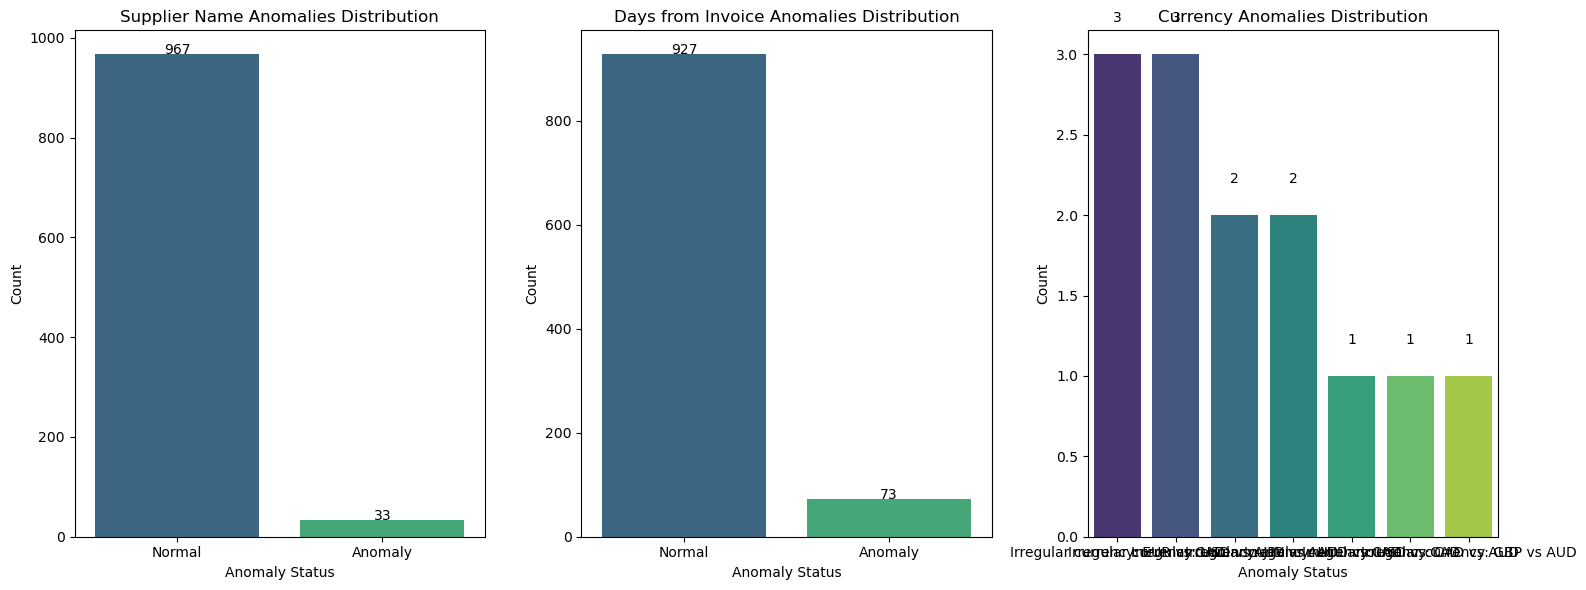

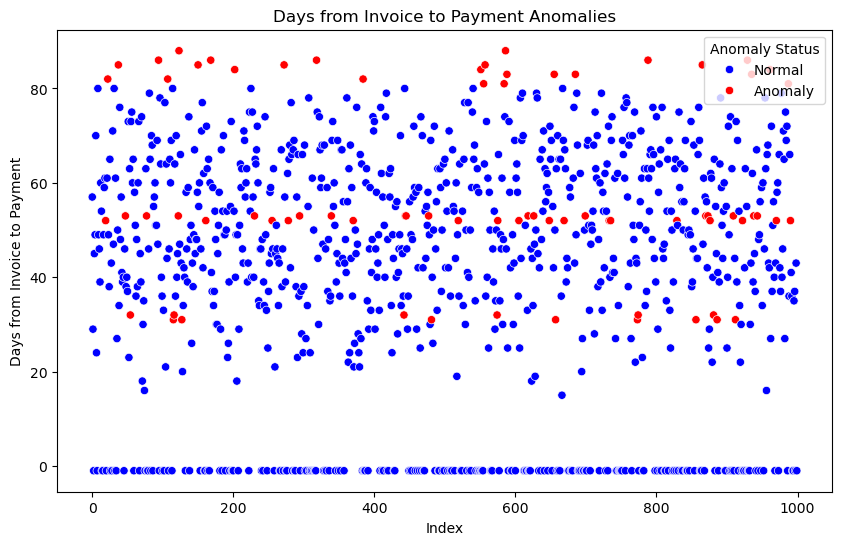

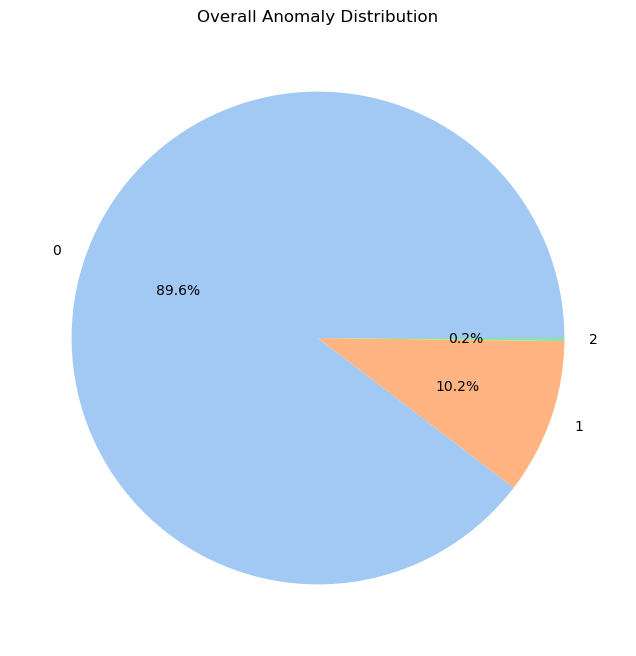

In [5]:
data = pd.read_csv('processed_data_with_anomalies.csv')
visualize_anomalies(data)